## Overview



This notebook is a simple implementation of GPT-2 model for text generation. The model is trained on the works of William Shakespeare. We built this model to benchmark EXAdam against the original Adam optimizer and other state-of-the-art optimizers.


## Importing Libraries


In [1]:
!pip install -q -U torch_optimizer

In [2]:
import numpy as np

import pandas as pd

import gc

import time

import torch

import torch.nn as nn

from torch.nn import functional as F

import random

import torch_optimizer as optim

import os



for dirname, _, filenames in os.walk("/kaggle/input"):

    for filename in filenames:

        print(os.path.join(dirname, filename))

/kaggle/input/shakespeare.txt


In [3]:
"""
Adapted from: https://pytorch.org/docs/1.6.0/_modules/torch/optim/adam.html
"""
import math
from torch.optim import Optimizer


def linear_warmup_scheduler(step, alpha_end, alpha_start=0, warmup=1):
    if step < warmup:
        a = step / float(warmup)
        return (1.0-a) * alpha_start + a * alpha_end
    return alpha_end


def linear_hl_warmup_scheduler(step, beta_end, beta_start=0, warmup=1):

    def f(beta, eps=1e-8):
        return math.log(0.5)/math.log(beta+eps)-1

    def f_inv(t):
        return math.pow(0.5, 1/(t+1))

    if step < warmup:
        a = step / float(warmup)
        return f_inv((1.0-a) * f(beta_start) + a * f(beta_end))
    return beta_end


class AdEMAMix(Optimizer):
    r"""Implements the AdEMAMix algorithm.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999, 0.9999)) 
            corresponding to beta_1, beta_2, beta_3 in AdEMAMix
        alpha (float): AdEMAMix alpha coeficient mixing the slow and fast EMAs (default: 2)
        beta3_warmup (int, optional): number of warmup steps used to increase beta3 (default: None)
        alpha_warmup: (int, optional): number of warmup steps used to increase alpha (default: None)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay as in AdamW (default: 0)
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999, 0.9999), alpha=2.0, 
                 beta3_warmup=None, alpha_warmup=None,  eps=1e-8,
                 weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError("Invalid beta parameter at index 2: {}".format(betas[2]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= alpha:
            raise ValueError("Invalid alpha value: {}".format(alpha))
        defaults = dict(lr=lr, betas=betas, eps=eps, alpha=alpha, beta3_warmup=beta3_warmup,
                        alpha_warmup=alpha_warmup, weight_decay=weight_decay)
        super(AdEMAMix, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdEMAMix, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            
            lr = group["lr"]
            lmbda = group["weight_decay"]
            eps = group["eps"]
            beta1, beta2, beta3_final = group["betas"]
            beta3_warmup = group["beta3_warmup"]
            alpha_final = group["alpha"]
            alpha_warmup = group["alpha_warmup"]
        
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('AdEMAMix does not support sparse gradients.')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    if beta1 != 0.0: # save memory in case beta1 is 0.0
                        state['exp_avg_fast'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    else: 
                        state['exp_avg_fast'] = None
                    state['exp_avg_slow'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg_fast, exp_avg_slow, exp_avg_sq = state['exp_avg_fast'], state['exp_avg_slow'], state['exp_avg_sq']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Compute the effective alpha and beta3 in case warmup is used 
                if alpha_warmup is not None:
                    alpha = linear_warmup_scheduler(state["step"], alpha_end=alpha_final, alpha_start=0, warmup=alpha_warmup)
                else:
                    alpha = alpha_final
                
                if beta3_warmup is not None:
                    beta3 = linear_hl_warmup_scheduler(state["step"], beta_end=beta3_final, beta_start=beta1, warmup=beta3_warmup)
                else:
                    beta3 = beta3_final

                # Decay the first and second moment running average coefficient
                if beta1 != 0.0:
                    exp_avg_fast.mul_(beta1).add_(grad, alpha=1 - beta1)
                else:
                    exp_avg_fast = grad
                exp_avg_slow.mul_(beta3).add_(grad, alpha=1 - beta3)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

                update = (exp_avg_fast.div(bias_correction1) + alpha * exp_avg_slow) / denom

                # decay
                update.add_(p, alpha=lmbda)

                p.add_(-lr * update)

        return loss


In [4]:
from typing import Any, Dict, Iterable, Tuple, Union



Params = Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]]



SQRT_2 = np.sqrt(2.0)





class EXAdam(torch.optim.Optimizer):

    def __init__(

        self,

        params: Params,  # Model parameters

        lr: Union[float, torch.Tensor] = 0.001,  # Learning rate (default: 0.001)

        betas: Tuple[float, float] = (

            0.9,

            0.999,

        ),  # Coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))

        eps: float = 1e-8,  # Epsilon value added to the denominator to improve numerical stability (default: 1e-8)

        weight_decay: float = 0.0,  # Weight decay (L2 penalty) (default: 0.0)

    ):

        if lr < 0.0:

            raise ValueError("Invalid learning rate: {}".format(lr))

        if betas[0] < 0.0 or betas[0] >= 1.0:

            raise ValueError("Invalid beta1 value: {}".format(betas[0]))

        if betas[1] < 0.0 or betas[1] >= 1.0:

            raise ValueError("Invalid beta2 value: {}".format(betas[1]))

        if eps < 0.0:

            raise ValueError("Invalid epsilon value: {}".format(eps))

        if weight_decay < 0.0:

            raise ValueError("Invalid weight decay: {}".format(weight_decay))



        defaults = dict(

            lr=lr,

            betas=betas,

            eps=eps,

            weight_decay=weight_decay,

        )

        super(EXAdam, self).__init__(params, defaults)



    def __setstate__(self, state):

        super(EXAdam, self).__setstate__(state)



    def step(self, closure=None):

        loss = None

        if closure is not None:

            loss = closure()



        for group in self.param_groups:

            lr: Union[float, torch.Tensor] = group["lr"]

            beta1: float

            beta2: float

            beta1, beta2 = group["betas"]

            eps: float = group["eps"]

            weight_decay: float = group["weight_decay"]

            for i, p in enumerate(group["params"]):

                if p.grad is None:

                    continue



                if p.grad.is_sparse:

                    raise RuntimeError(

                        "EXAdam does not support sparse gradients, please consider SparseAdam instead"

                    )



                grad: torch.Tensor = p.grad.data



                state = self.state[p]



                if weight_decay != 0.0:

                    p.data.add_(p.data, alpha=lr * -weight_decay)



                if len(state) == 0:

                    state["step"] = 0

                    state["m"] = torch.zeros_like(p.data)

                    state["v"] = torch.zeros_like(p.data)



                m: torch.Tensor = state["m"]

                v: torch.Tensor = state["v"]



                state["step"] += 1



                step: int = state["step"]



                beta1_t: float = beta1**step

                beta2_t: float = beta2**step



                bias_correction1: float = 1 - beta1_t

                bias_correction2: float = 1 - beta2_t



                # Update biased first and second moment estimates

                m.mul_(beta1).add_(other=grad, alpha=1 - beta1)

                v.mul_(beta2).addcmul_(tensor1=grad, tensor2=grad, value=1 - beta2)



                # Introduce a new debiasing terms

                # m_tilde = m / (1 - β1^t) * (1 + (v / (v + ε)) * (β2^t))

                # v_tilde = v / (1 - β2^t) * (1 + (m^2 / (m^2 + ε)) * (β1^t))

                d1: torch.Tensor = 1 + (v.div(v + eps)) * beta2_t

                d2: torch.Tensor = 1 + (m.pow(2).div(m.pow(2) + eps)) * beta1_t



                m_tilde: torch.Tensor = m.div(bias_correction1) * d1

                v_tilde: torch.Tensor = v.div(bias_correction2) * d2



                # Bias-corrected gradient

                g_tilde = grad.div(bias_correction1) * d1



                # Compute the step size

                step_size = lr * np.log(np.sqrt(step + 1) * np.sqrt(2))



                # Update the parameters

                theta: torch.Tensor = (

                    -step_size * (m_tilde + g_tilde) / (v_tilde.sqrt() + eps)

                )



                p.data.add_(theta)



        return loss


In [5]:
class Signum(torch.optim.Optimizer):

    r"""Implements Signum optimizer that takes the sign of gradient or momentum.



    See details in the original paper at: https://arxiv.org/abs/1711.05101



    Args:

        params (iterable): iterable of parameters to optimize or dicts defining

            parameter groups

        lr (float): learning rate

        momentum (float, optional): momentum factor (default: 0.9)

        weight_decay (float, optional): weight decay (default: 0)



    Example:

        >>> optimizer = signum.Signum(model.parameters(), lr=0.1, momentum=0.9)

        >>> optimizer.zero_grad()

        >>> loss_fn(model(input), target).backward()

        >>> optimizer.step()



    .. note::

        The optimizer updates the weight by:

            buf = momentum * buf + (1-momentum)*rescaled_grad

            weight = (1 - lr * weight_decay) * weight - lr * sign(buf)



        Considering the specific case of Momentum, the update Signum can be written as



        .. math::

                \begin{split}g_t = \nabla J(W_{t-1})\\

			    m_t = \beta m_{t-1} + (1 - \beta) g_t\\

				W_t = W_{t-1} - \eta_t \text{sign}(m_t)}\end{split}



        where p, g, v and :math:`\rho` denote the parameters, gradient,

        velocity, and momentum respectively.



        If do not consider Momentum, the update Sigsgd can be written as



        .. math::

            	g_t = \nabla J(W_{t-1})\\

				W_t = W_{t-1} - \eta_t \text{sign}(g_t)}



    """



    def __init__(self, params, lr=0.01, momentum=0.09, weight_decay=0, **kwargs):

        if not 0.0 <= lr:

            raise ValueError("Invalid learning rate: {}".format(lr))

        if not 0.0 <= momentum:

            raise ValueError("Invalid momentum value: {}".format(momentum))

        if not 0.0 <= weight_decay:

            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))



        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)



        super(Signum, self).__init__(params, defaults)



    def __setstate__(self, state):

        super(Signum, self).__setstate__(state)



    def step(self, closure=None):

        loss = None

        if closure is not None:

            loss = closure()



        for group in self.param_groups:

            weight_decay = group["weight_decay"]

            momentum = group["momentum"]



            for p in group["params"]:

                if p.grad is None:

                    continue

                d_p = p.grad.data

                if weight_decay != 0:

                    d_p.add_(weight_decay, p.data)

                if momentum != 0:

                    # signum

                    param_state = self.state[p]

                    if "momentum_buffer" not in param_state:

                        buf = param_state["momentum_buffer"] = torch.zeros_like(p.data)



                    else:

                        buf = param_state["momentum_buffer"]



                    buf.mul_(momentum).add_((1 - momentum), d_p)

                    d_p = torch.sign(buf)

                else:  # signsgd

                    d_p = torch.sign(d_p)



                p.data.add_(-group["lr"], d_p)



        return loss

## Setting up the Environment


In [6]:
SEED = 1234





# Ensure reproducibility

def set_seed(seed):

    random.seed(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)

    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True

    torch.backends.cudnn.benchmark = False

    os.environ["PYTHONHASHSEED"] = str(seed)





set_seed(SEED)

In [7]:
# Hyperparameters

batch_size = 64  # Number of independent sequences to process in parallel

block_size = 256  # Number of tokens to process at once (length of the sequence)

max_iters = 5000  # Number of batches to train for

eval_interval = 500  # Frequency of model evaluation during training

lr = 1e-4  # Learning rate for the optimizer

device = torch.device(

    "cuda" if torch.cuda.is_available() else "cpu"

)  # Device to use for training (GPU or CPU)

eval_iters = 200  # Number of batches to use for evaluation

n_embed = 384  # Size of the token embedding

n_heads = 8  # Number of attention heads

n_layers = 8  # Number of transformer layers

dropout = 0.2  # Dropout rate for regularization

## Importing the Dataset


In [8]:
# Read the text file

with open("/kaggle/input/shakespeare.txt", "r", encoding="utf-8") as f:

    text = f.read()



# Create a list of unique characters and determine the vocabulary size

chars = sorted(list(set(text)))

vocab_size = len(chars)



# Create mappings from characters to indices and vice versa

char_to_idx = {c: i for i, c in enumerate(chars)}

idx_to_char = {i: c for i, c in enumerate(chars)}





# Define encoding and decoding functions

def encode(s):

    """Encode a string into a tensor of indices."""

    return torch.tensor([char_to_idx[c] for c in s], dtype=torch.long)





def decode(indices):

    """Decode a tensor of indices back into a string."""

    return "".join([idx_to_char[i] for i in indices])





# Split the data into training and validation sets

data = torch.tensor(encode(text), dtype=torch.long)

n = int(len(data) * 0.9)

train_data = data[:n]

val_data = data[n:]





# Data loading function

def get_batch(split):

    """Generate a small batch of data of inputs x and targets y."""

    data = train_data if split == "train" else val_data

    ix = torch.randint(len(data) - block_size - 1, (batch_size,))

    x = torch.stack([data[i : i + block_size] for i in ix])

    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])

    return x.to(device), y.to(device)





# Function to estimate the loss

@torch.no_grad()

def estimate_loss(model):

    """Estimate the loss on the training and validation sets."""

    model.eval()  # Set the model to evaluation mode

    out = {}

    for split in ["train", "val"]:

        losses = torch.zeros(eval_iters)

        for k in range(eval_iters):

            x, y = get_batch(split)

            logits, loss = model(x, y)

            losses[k] = loss.item()

        out[split] = losses.mean()

    model.train()  # Set the model back to training mode

    return out





# Self-Attention Head

class Head(nn.Module):

    """One head of self-attention."""



    def __init__(self, head_size, n_embed, block_size, dropout):

        super().__init__()

        self.key = nn.Linear(n_embed, head_size, bias=False)

        self.query = nn.Linear(n_embed, head_size, bias=False)

        self.value = nn.Linear(n_embed, head_size, bias=False)

        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)



    def forward(self, x):

        B, T, C = x.shape

        k = self.key(x)  # (B, T, head_size)

        q = self.query(x)  # (B, T, head_size)

        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, T)

        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B, T, T)

        wei = F.softmax(wei, dim=-1)  # (B, T, T)

        wei = self.dropout(wei)

        v = self.value(x)  # (B, T, head_size)

        out = wei @ v  # (B, T, head_size)

        return out





# Multi-Head Self-Attention

class MultiHeadAttention(nn.Module):

    """Multiple heads of self-attention in parallel."""



    def __init__(self, num_heads, head_size, n_embed, dropout):

        super().__init__()

        self.heads = nn.ModuleList(

            [Head(head_size, n_embed, block_size, dropout) for _ in range(num_heads)]

        )

        self.proj = nn.Linear(n_embed, n_embed)

        self.dropout = nn.Dropout(dropout)



    def forward(self, x):

        out = torch.cat([h(x) for h in self.heads], dim=-1)

        out = self.dropout(self.proj(out))

        return out





# Feed-Forward Network

class FeedForward(nn.Module):

    """A simple linear layer followed by a non-linearity."""



    def __init__(self, n_embed, dropout):

        super().__init__()

        self.net = nn.Sequential(

            nn.Linear(n_embed, 4 * n_embed),

            nn.ReLU(),

            nn.Linear(4 * n_embed, n_embed),

            nn.Dropout(dropout),

        )



    def forward(self, x):

        return self.net(x)





# Transformer Block

class Block(nn.Module):

    """Transformer block: communication followed by computation."""



    def __init__(self, n_embed, n_head, dropout):

        super().__init__()

        head_size = n_embed // n_head

        self.sa = MultiHeadAttention(n_head, head_size, n_embed, dropout)

        self.ff = FeedForward(n_embed, dropout)

        self.ln1 = nn.LayerNorm(n_embed)

        self.ln2 = nn.LayerNorm(n_embed)



    def forward(self, x):

        x = x + self.sa(self.ln1(x))

        x = x + self.ff(self.ln2(x))

        return x





# Bigram Language Model

class BigramLanguageModel(nn.Module):

    """A simple bigram language model."""



    def __init__(self):

        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)

        self.position_embedding_table = nn.Embedding(block_size, n_embed)

        self.blocks = nn.Sequential(

            *[Block(n_embed, n_heads, dropout) for _ in range(n_layers)]

        )

        self.ln_f = nn.LayerNorm(n_embed)

        self.lm_head = nn.Linear(n_embed, vocab_size)



    def forward(self, idx, targets=None):

        B, T = idx.shape

        token_emb = self.token_embedding_table(idx)  # (B, T, C)

        pos_emb = self.position_embedding_table(

            torch.arange(T, device=idx.device)

        )  # (T, C)

        x = token_emb + pos_emb  # (B, T, C)

        x = self.blocks(x)  # (B, T, C)

        x = self.ln_f(x)  # (B, T, C)

        logits = self.lm_head(x)  # (B, T, vocab_size)



        if targets is None:

            return logits, None

        else:

            B, T, C = logits.shape

            logits = logits.view(B * T, C)

            targets = targets.view(B * T)

            loss = F.cross_entropy(logits, targets)

            return logits, loss



    def generate(self, idx, max_new_tokens):

        """Generate new tokens using the model."""

        B, T = idx.shape

        for _ in range(max_new_tokens):

            idx_cond = idx[:, -block_size:]

            logits, _ = self(idx_cond)

            logits = logits[:, -1, :]  # (B, C)

            probs = F.softmax(logits, dim=-1)  # (B, C)

            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)

            idx = torch.cat([idx, idx_next], dim=1)  # (B, T+1)

        return idx

/tmp/ipykernel_23/197938893.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(encode(text), dtype=torch.long)


## Training the Models


In [9]:
adam_model = BigramLanguageModel().to(device)

adamw_model = BigramLanguageModel().to(device)

exadam_model = BigramLanguageModel().to(device)

sgd_model = BigramLanguageModel().to(device)

signum_model = BigramLanguageModel().to(device)

adafactor_model = BigramLanguageModel().to(device)

ademamix_model = BigramLanguageModel().to(device)



print(f"Number of parameters: {sum(p.numel() for p in adam_model.parameters())}")

Number of parameters: 14335553


In [10]:
adam_optimizer = torch.optim.Adam(adam_model.parameters(), lr=lr)

adamw_optimizer = torch.optim.AdamW(adamw_model.parameters(), lr=lr)

exadam_optimizer = EXAdam(exadam_model.parameters(), lr=lr)

sgd_optimizer = torch.optim.SGD(sgd_model.parameters(), lr=lr, momentum=0.9)

signum_optimizer = Signum(signum_model.parameters(), lr=lr, momentum=0.9)

adafactor_optimizer = optim.Adafactor(adafactor_model.parameters(), lr=lr)

ademamix_optimizer = AdEMAMix(ademamix_model.parameters(), lr=lr)

In [11]:
def train(model, optimizer):

    """

    Train the model using the provided optimizer.



    Args:

        model (nn.Module): The model to train.

        optimizer (torch.optim.Optimizer): The optimizer to use for training.

        max_iters (int): The maximum number of training iterations.

        eval_interval (int): The interval at which to evaluate the model on the validation set.

        block_size (int): The block size for the data batches.

        batch_size (int): The batch size for the data batches.

        device (str): The device to use for training (e.g., 'cuda' or 'cpu').



    Returns:

        tuple: A tuple containing two lists: training losses and validation losses.

    """

    training_losses = []

    validation_losses = []



    for iter in range(max_iters):

        # Get a batch of data

        x, y = get_batch("train")



        # Compute the logits and loss

        logits, loss = model(x, y)



        # Compute the gradients

        loss.backward()



        # Update the parameters

        optimizer.step()



        # Zero the gradients

        optimizer.zero_grad(set_to_none=True)



        # Store the loss

        loss_item = loss.item()

        training_losses.append(loss_item)



        # Print the loss

        if (iter + 1) % 100 == 0 or iter == 0:

            print(f"Iteration {iter + 1:4d}: train loss {loss_item:.3f}")



        # Evaluate the model

        if (iter + 1) % eval_interval == 0:

            losses = estimate_loss(model)

            validation_losses.append(losses["val"])

            print(

                f'Iteration {iter + 1:4d}: train loss {losses["train"]:.3f}, val loss {losses["val"]:.3f}'

            )



            # Optionally, generate some text

            # x = torch.tensor([[ctoi['a']]]).to(device)

            # x = model.generate(x, 100)

            # print(decode(x[0].tolist()))

            print("")



    return training_losses, validation_losses





def train_with_logging(model, optimizer, optimizer_name):

    print(f"\n>>> {optimizer_name} Started >>>")

    start_time: float = time.time()

    loss_hist, loss_hist_val = train(model, optimizer)

    print(f"Training Time for {optimizer_name}: {time.time() - start_time}")

    # Remove the model from the GPU to avoid memory leaks

    with torch.no_grad():

        model.cpu()

        del model

        torch.cuda.empty_cache()

        gc.collect()

    return loss_hist, loss_hist_val





exadam_loss_hist, exadam_loss_hist_val = train_with_logging(

    exadam_model, exadam_optimizer, "EXAdam"

)

adam_loss_hist, adam_loss_hist_val = train_with_logging(

    adam_model, adam_optimizer, "Adam"

)

adamw_loss_hist, adamw_loss_hist_val = train_with_logging(

    adamw_model, adamw_optimizer, "AdamW"

)

adafactor_loss_hist, adafactor_loss_hist_val = train_with_logging(

    adafactor_model, adafactor_optimizer, "AdaFactor"

)

signum_loss_hist, signum_loss_hist_val = train_with_logging(

    signum_model, signum_optimizer, "Signum"

)

sgd_loss_hist, sgd_loss_hist_val = train_with_logging(

    sgd_model, sgd_optimizer, "SGD with Momentum"

)

ademamix_loss_hist, ademamix_loss_hist_val = train_with_logging(

    ademamix_model, ademamix_optimizer, "AdEMAMix"

)



>>> EXAdam Started >>>
Iteration    1: train loss 4.335
Iteration  100: train loss 2.527
Iteration  200: train loss 2.427
Iteration  300: train loss 2.378
Iteration  400: train loss 2.172
Iteration  500: train loss 1.956
Iteration  500: train loss 1.912, val loss 2.010

Iteration  600: train loss 1.840
Iteration  700: train loss 1.690
Iteration  800: train loss 1.602
Iteration  900: train loss 1.568
Iteration 1000: train loss 1.551
Iteration 1000: train loss 1.443, val loss 1.658

Iteration 1100: train loss 1.462
Iteration 1200: train loss 1.421
Iteration 1300: train loss 1.369
Iteration 1400: train loss 1.344
Iteration 1500: train loss 1.321
Iteration 1500: train loss 1.256, val loss 1.523

Iteration 1600: train loss 1.309
Iteration 1700: train loss 1.295
Iteration 1800: train loss 1.282
Iteration 1900: train loss 1.248
Iteration 2000: train loss 1.199
Iteration 2000: train loss 1.150, val loss 1.497

Iteration 2100: train loss 1.186
Iteration 2200: train loss 1.176
Iteration 2300: t

/tmp/ipykernel_23/2297887785.py:161: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/python_arg_parser.cpp:1581.)
  buf.mul_(momentum).add_((1 - momentum), d_p)


Iteration    1: train loss 4.300
Iteration  100: train loss 2.475
Iteration  200: train loss 2.390
Iteration  300: train loss 2.230
Iteration  400: train loss 2.085
Iteration  500: train loss 1.935
Iteration  500: train loss 1.887, val loss 2.000

Iteration  600: train loss 1.865
Iteration  700: train loss 1.754
Iteration  800: train loss 1.695
Iteration  900: train loss 1.610
Iteration 1000: train loss 1.602
Iteration 1000: train loss 1.516, val loss 1.714

Iteration 1100: train loss 1.544
Iteration 1200: train loss 1.522
Iteration 1300: train loss 1.479
Iteration 1400: train loss 1.467
Iteration 1500: train loss 1.452
Iteration 1500: train loss 1.362, val loss 1.589

Iteration 1600: train loss 1.397
Iteration 1700: train loss 1.375
Iteration 1800: train loss 1.368
Iteration 1900: train loss 1.369
Iteration 2000: train loss 1.314
Iteration 2000: train loss 1.278, val loss 1.546

Iteration 2100: train loss 1.329
Iteration 2200: train loss 1.317
Iteration 2300: train loss 1.307
Iteratio

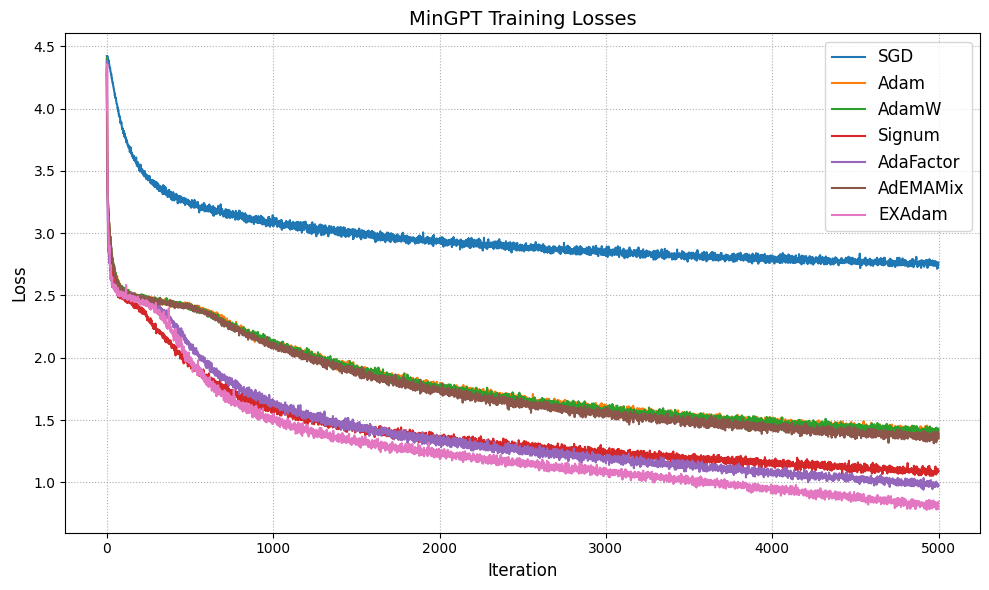

In [12]:
import matplotlib.pyplot as plt



# Set global Matplotlib parameters for better visualization

plt.rcParams.update({

    "axes.labelsize": 12,

    "axes.titlesize": 14,

    "legend.fontsize": 12,

    "xtick.labelsize": 10,

    "ytick.labelsize": 10

})



# Plot the training losses for different optimizers

plt.figure(figsize=(10, 6))



# Plot the loss history for each optimizer

plt.plot(sgd_loss_hist, label="SGD")

plt.plot(adam_loss_hist, label="Adam")

plt.plot(adamw_loss_hist, label="AdamW")

plt.plot(signum_loss_hist, label="Signum")

plt.plot(adafactor_loss_hist, label="AdaFactor")

plt.plot(ademamix_loss_hist, label="AdEMAMix")

plt.plot(exadam_loss_hist, label="EXAdam")



# Add labels and title

plt.xlabel("Iteration")

plt.ylabel("Loss")

plt.title("MinGPT Training Losses")



# Add legend and grid

plt.legend()

plt.grid(linestyle="dotted")



# Adjust layout to fit everything nicely

plt.tight_layout()



# Save the plot to a file

plt.savefig("./mingpt_training_loss.png", dpi=300)



# Display the plot

plt.show()

In [13]:
def generate_text(model, max_new_tokens, output_file=None):

    """

    Generate text from the model and optionally write it to a file.



    Args:

        model (nn.Module): The trained model to use for text generation.

        max_new_tokens (int): The maximum number of new tokens to generate.

        output_file (str, optional): The file to write the generated text to. If None, the text is only printed to the console.

    """

    # Create an initial context with a single token (e.g., a space)

    context = torch.zeros((1, 1), dtype=torch.long, device=device)



    # Generate text and decode it

    generated_tokens = model.generate(context, max_new_tokens=max_new_tokens)

    generated_text = decode(generated_tokens[0].tolist())



    # Print the generated text to the console

    print(generated_text)



    # Optionally, write the generated text to a file

    if output_file:

        with open(output_file, "w", encoding="utf-8") as f:

            f.write(generated_text)